In [ ]:
#|default_exp models.TSSequencerPlus

# TSSequencerPlus

>This is a PyTorch implementation created by Ignacio Oguiza (oguiza@timeseriesAI.co) based on Sequencer: Deep LSTM for Image Classification

In [ ]:
#|export
from tsai.imports import *
from tsai.models.utils import *
from tsai.models.layers import *
from typing import Callable

In [ ]:
#|export
class _TSSequencerEncoderLayer(nn.Module):
    def __init__(self, d_model:int, q_len:int=None, lstm_dropout:float=0., dropout:float=0, drop_path_rate:float=0.,
                 mlp_ratio:int=1, lstm_bias:bool=True, act:str='gelu', pre_norm:bool=False):
        super().__init__()
        self.bilstm = nn.LSTM(q_len, q_len, num_layers=1, bidirectional=True, bias=lstm_bias)
        self.dropout = nn.Dropout(lstm_dropout) if lstm_dropout else nn.Identity()
        self.fc = nn.Linear(2 * q_len, q_len)
        self.lstm_norm = nn.LayerNorm(d_model)
        self.pwff =  PositionwiseFeedForward(d_model, dropout=dropout, act=act, mlp_ratio=mlp_ratio)
        self.ff_norm = nn.LayerNorm(d_model)
        self.drop_path = DropPath(drop_path_rate) if drop_path_rate != 0 else nn.Identity()
        self.pre_norm = pre_norm
        self.transpose = Transpose(1,2)

    def forward(self, x):
        if self.pre_norm:
            x = self.drop_path(self.dropout(self.transpose(self.fc(self.bilstm(self.transpose(self.lstm_norm(x)))[0])))) + x
            x = self.drop_path(self.pwff(self.ff_norm(x))) + x
        else:
            x = self.lstm_norm(self.drop_path(self.dropout(self.transpose(self.fc(self.bilstm(self.transpose(x))[0])))) + x)
            x = self.ff_norm(self.drop_path(self.pwff(x)) + x)
        return x

In [ ]:
#|export
class _TSSequencerEncoder(nn.Module):
    def __init__(self, d_model, depth:int=6, q_len:int=None, lstm_dropout:float=0., dropout:float=0, drop_path_rate:float=0.,
                 mlp_ratio:int=1, lstm_bias:bool=True, act:str='gelu', pre_norm:bool=False):
        super().__init__()
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]
        layers = []
        for i in range(depth):
            layer = _TSSequencerEncoderLayer(d_model, q_len=q_len, lstm_dropout=lstm_dropout, dropout=dropout, drop_path_rate=dpr[i],
                                      mlp_ratio=mlp_ratio, lstm_bias=lstm_bias, act=act, pre_norm=pre_norm)
            layers.append(layer)
        self.encoder = nn.Sequential(*layers)
        self.norm = nn.LayerNorm(d_model) if pre_norm else nn.Identity()

    def forward(self, x):
        x = self.encoder(x)
        x = self.norm(x)
        return x

In [ ]:
#|export
class _TSSequencerBackbone(Module):
    def __init__(self, c_in:int, seq_len:int, depth:int=6, d_model:int=128, act:str='gelu',
                 lstm_bias:bool=True, lstm_dropout:float=0., dropout:float=0., drop_path_rate:float=0., mlp_ratio:int=1,
                 pre_norm:bool=False, use_token:bool=True,  use_pe:bool=True, n_cat_embeds:Optional[list]=None, cat_embed_dims:Optional[list]=None,
                 cat_padding_idxs:Optional[list]=None, cat_pos:Optional[list]=None, feature_extractor:Optional[Callable]=None,
                 token_size:int=None, tokenizer:Optional[Callable]=None):

        # Categorical embeddings
        if n_cat_embeds is not None:
            n_cat_embeds = listify(n_cat_embeds)
            if cat_embed_dims is None:
                cat_embed_dims = [emb_sz_rule(s) for s in n_cat_embeds]
            self.to_cat_embed = MultiEmbedding(c_in, n_cat_embeds, cat_embed_dims=cat_embed_dims, cat_padding_idxs=cat_padding_idxs, cat_pos=cat_pos)
            c_in, seq_len = output_size_calculator(self.to_cat_embed, c_in, seq_len)
        else:
            self.to_cat_embed = nn.Identity()

        # Sequence embedding
        if token_size is not None:
            self.tokenizer = SeqTokenizer(c_in, d_model, token_size)
            c_in, seq_len = output_size_calculator(self.tokenizer, c_in, seq_len)
        elif tokenizer is not None:
            if isinstance(tokenizer, nn.Module):  self.tokenizer = tokenizer
            else: self.tokenizer = tokenizer(c_in, d_model)
            c_in, seq_len = output_size_calculator(self.tokenizer, c_in, seq_len)
        else:
            self.tokenizer = nn.Identity()

        # Feature extractor
        if feature_extractor is not None:
            if isinstance(feature_extractor, nn.Module):  self.feature_extractor = feature_extractor
            else: self.feature_extractor = feature_extractor(c_in, d_model)
            c_in, seq_len = output_size_calculator(self.feature_extractor, c_in, seq_len)
        else:
            self.feature_extractor = nn.Identity()

        # Linear projection
        if token_size is None and tokenizer is None and feature_extractor is None:
            self.linear_proj = nn.Conv1d(c_in, d_model, 1)
        else:
            self.linear_proj = nn.Identity()

        self.transpose = Transpose(1,2)

        # Position embedding & token
        if use_pe:
            self.pos_embed = nn.Parameter(torch.zeros(1, seq_len, d_model))
        self.use_pe = use_pe
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
        self.use_token = use_token
        self.emb_dropout = nn.Dropout(dropout) if dropout else nn.Identity()

        # Encoder
        self.encoder = _TSSequencerEncoder(d_model, depth=depth, q_len=seq_len + use_token, lstm_bias=lstm_bias,
                                         lstm_dropout=lstm_dropout, dropout=dropout,
                                         mlp_ratio=mlp_ratio, drop_path_rate=drop_path_rate, act=act, pre_norm=pre_norm)

    def forward(self, x):

        # Categorical embeddings
        x = self.to_cat_embed(x)

        # Sequence embedding
        x = self.tokenizer(x)

        # Feature extractor
        x = self.feature_extractor(x)

        # Linear projection
        x = self.linear_proj(x)

        # Position embedding & token
        x = self.transpose(x)
        if self.use_pe:
            x = x + self.pos_embed
        if self.use_token: # token is concatenated after position embedding so that embedding can be learned using self.supervised learning
            x = torch.cat((self.cls_token.expand(x.shape[0], -1, -1), x), dim=1)
        x = self.emb_dropout(x)

        # Encoder
        x = self.encoder(x)

        # Output
        x = x.transpose(1,2)
        return x

In [ ]:
#|exports
class TSSequencerPlus(nn.Sequential):
    r"""Time Series Sequencer model based on:

    Tatsunami, Y., & Taki, M. (2022). Sequencer: Deep LSTM for Image Classification. arXiv preprint arXiv:2205.01972.
    Official implementation: https://github.com/okojoalg/sequencer

    Args:
        c_in:               the number of features (aka variables, dimensions, channels) in the time series dataset.
        c_out:              the number of target classes.
        seq_len:            number of time steps in the time series.
        d_model:            total dimension of the model (number of features created by the model).
        depth:              number of blocks in the encoder.
        act:                the activation function of positionwise feedforward layer.
        lstm_dropout:       dropout rate applied to the lstm sublayer.
        dropout:            dropout applied to to the embedded sequence steps after position embeddings have been added and
                            to the mlp sublayer in the encoder.
        drop_path_rate:     stochastic depth rate.
        mlp_ratio:          ratio of mlp hidden dim to embedding dim.
        lstm_bias:          determines whether bias is applied to the LSTM layer.
        pre_norm:           if True normalization will be applied as the first step in the sublayers. Defaults to False.
        use_token:          if True, the output will come from the transformed token. This is meant to be use in classification tasks.
        use_pe:             flag to indicate if positional embedding is used.
        n_cat_embeds:       list with the sizes of the dictionaries of embeddings (int).
        cat_embed_dims:     list with the sizes of each embedding vector (int).
        cat_padding_idxs:       If specified, the entries at cat_padding_idxs do not contribute to the gradient; therefore, the embedding vector at cat_padding_idxs
                            are not updated during training. Use 0 for those categorical embeddings that may have #na# values. Otherwise, leave them as None.
                            You can enter a combination for different embeddings (for example, [0, None, None]).
        cat_pos:            list with the position of the categorical variables in the input.
        token_size:         Size of the embedding function used to reduce the sequence length (similar to ViT's patch size)
        tokenizer:          nn.Module or callable that will be used to reduce the sequence length
        feature_extractor:  nn.Module or callable that will be used to preprocess the time series before
                            the embedding step. It is useful to extract features or resample the time series.
        flatten:            flag to indicate if the 3d logits will be flattened to 2d in the model's head if use_token is set to False.
                            If use_token is False and flatten is False, the model will apply a pooling layer.
        concat_pool:        if True the head begins with fastai's AdaptiveConcatPool2d if concat_pool=True; otherwise, it uses traditional average pooling.
        fc_dropout:         dropout applied to the final fully connected layer.
        use_bn:             flag that indicates if batchnorm will be applied to the head.
        bias_init:          values used to initialized the output layer.
        y_range:            range of possible y values (used in regression tasks).
        custom_head:        custom head that will be applied to the network. It must contain all kwargs (pass a partial function)
        verbose:            flag to control verbosity of the model.

    Input:
        x: bs (batch size) x nvars (aka features, variables, dimensions, channels) x seq_len (aka time steps)
    """

    def __init__(self, c_in:int, c_out:int, seq_len:int, d_model:int=128, depth:int=6, act:str='gelu',
                 lstm_dropout:float=0., dropout:float=0., drop_path_rate:float=0., mlp_ratio:int=1, lstm_bias:bool=True,
                 pre_norm:bool=False, use_token:bool=False, use_pe:bool=True,
                 cat_pos:Optional[list]=None, n_cat_embeds:Optional[list]=None, cat_embed_dims:Optional[list]=None, cat_padding_idxs:Optional[list]=None,
                 token_size:int=None, tokenizer:Optional[Callable]=None, feature_extractor:Optional[Callable]=None,
                 flatten:bool=False, concat_pool:bool=True, fc_dropout:float=0., use_bn:bool=False,
                 bias_init:Optional[Union[float, list]]=None, y_range:Optional[tuple]=None, custom_head:Optional[Callable]=None, verbose:bool=True,
                 **kwargs):

        if use_token and c_out == 1:
            use_token = False
            pv("use_token set to False as c_out == 1", verbose)
        backbone = _TSSequencerBackbone(c_in, seq_len, depth=depth, d_model=d_model, act=act,
                                      lstm_dropout=lstm_dropout, dropout=dropout, drop_path_rate=drop_path_rate,
                                      pre_norm=pre_norm, mlp_ratio=mlp_ratio, use_pe=use_pe, use_token=use_token,
                                      n_cat_embeds=n_cat_embeds, cat_embed_dims=cat_embed_dims, cat_padding_idxs=cat_padding_idxs, cat_pos=cat_pos,
                                      feature_extractor=feature_extractor, token_size=token_size, tokenizer=tokenizer)

        self.head_nf = d_model
        self.c_out = c_out
        self.seq_len = seq_len

        # Head
        if custom_head:
            if isinstance(custom_head, nn.Module): head = custom_head
            else: head = custom_head(self.head_nf, c_out, seq_len, **kwargs)
        else:
            nf = d_model
            layers = []
            if use_token:
                layers += [TokenLayer()]
            elif flatten:
                layers += [Reshape(-1)]
                nf = nf * seq_len
            else:
                if concat_pool: nf *= 2
                layers = [GACP1d(1) if concat_pool else GAP1d(1)]
            if use_bn: layers += [nn.BatchNorm1d(nf)]
            if fc_dropout: layers += [nn.Dropout(fc_dropout)]

            # Last layer
            linear = nn.Linear(nf, c_out)
            if bias_init is not None:
                if isinstance(bias_init, float): nn.init.constant_(linear.bias, bias_init)
                else: linear.bias = nn.Parameter(torch.as_tensor(bias_init, dtype=torch.float32))
            layers += [linear]

            if y_range: layers += [SigmoidRange(*y_range)]
            head = nn.Sequential(*layers)
        super().__init__(OrderedDict([('backbone', backbone), ('head', head)]))


TSSequencer = TSSequencerPlus

In [ ]:
bs = 16
nvars = 4
seq_len = 50
c_out = 2
xb = torch.rand(bs, nvars, seq_len)
model = TSSequencerPlus(nvars, c_out, seq_len)

In [ ]:
bs = 16
nvars = 4
seq_len = 50
c_out = 2
xb = torch.rand(bs, nvars, seq_len)
model = TSSequencerPlus(nvars, c_out, seq_len, lstm_dropout=.1, dropout=.1, use_token=True)
test_eq(model(xb).shape, (bs, c_out))
model = TSSequencerPlus(nvars, c_out, seq_len, lstm_dropout=.1, dropout=.1, use_token=False)
test_eq(model(xb).shape, (bs, c_out))

In [ ]:
bs = 16
nvars = 4
seq_len = 50
c_out = 2
xb = torch.rand(bs, nvars, seq_len)
bias_init = np.array([0.8, .2])
model = TSSequencerPlus(nvars, c_out, seq_len, bias_init=bias_init)
test_eq(model(xb).shape, (bs, c_out))
test_eq(model.head[1].bias.data, tensor(bias_init))

In [ ]:
bs = 16
nvars = 4
seq_len = 50
c_out = 1
xb = torch.rand(bs, nvars, seq_len)
bias_init = 8.5
model = TSSequencerPlus(nvars, c_out, seq_len, bias_init=bias_init)
test_eq(model(xb).shape, (bs, c_out))
test_eq(model.head[1].bias.data, tensor([bias_init]))

In [ ]:
bs = 16
nvars = 4
seq_len = 50
c_out = 2
xb = torch.rand(bs, nvars, seq_len)
bias_init = np.array([0.8, .2])
model = TSSequencerPlus(nvars, c_out, seq_len, bias_init=bias_init)
test_eq(model(xb).shape, (bs, c_out))
test_eq(model.head[1].bias.data, tensor(bias_init))

## Feature extractor

It's a known fact that transformers cannot be directly applied to long sequences. To avoid this, we have included a way to subsample the sequence to generate a more manageable input.

In [ ]:
from tsai.data.validation import get_splits
from tsai.data.core import get_ts_dls

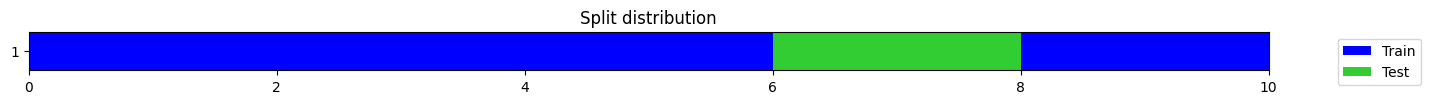

TSTensor(samples:8, vars:3, len:5000, device=mps:0, dtype=torch.float32)

In [ ]:
X = np.zeros((10, 3, 5000))
y = np.random.randint(0,2,X.shape[0])
splits = get_splits(y)
dls = get_ts_dls(X, y, splits=splits)
xb, yb = dls.train.one_batch()
xb

If you try to use SequencerPlus, it's likely you'll get an 'out-of-memory' error.

To avoid this you can subsample the sequence reducing the input's length. This can be done in multiple ways. Here are a few examples: 

In [ ]:
# Separable convolution (to avoid mixing channels)
feature_extractor = Conv1d(xb.shape[1], xb.shape[1], ks=100, stride=50, padding=0, groups=xb.shape[1]).to(default_device())
feature_extractor.to(xb.device)(xb).shape

torch.Size([8, 3, 99])

In [ ]:
# Convolution (if you want to mix channels or change number of channels)
feature_extractor=MultiConv1d(xb.shape[1], 64, kss=[1,3,5,7,9], keep_original=True).to(default_device())
test_eq(feature_extractor.to(xb.device)(xb).shape, (xb.shape[0], 64, xb.shape[-1]))

In [ ]:
# MaxPool
feature_extractor = nn.Sequential(Pad1d((0, 50), 0), nn.MaxPool1d(kernel_size=100, stride=50)).to(default_device())
feature_extractor.to(xb.device)(xb).shape

torch.Size([8, 3, 100])

In [ ]:
# AvgPool
feature_extractor = nn.Sequential(Pad1d((0, 50), 0), nn.AvgPool1d(kernel_size=100, stride=50)).to(default_device())
feature_extractor.to(xb.device)(xb).shape

torch.Size([8, 3, 100])

Once you decide what type of transform you want to apply, you just need to pass the layer as the feature_extractor attribute:

In [ ]:
bs = 16
nvars = 4
seq_len = 1000
c_out = 2
d_model = 128

xb = torch.rand(bs, nvars, seq_len)
feature_extractor = partial(Conv1d, ks=5, stride=3, padding=0, groups=xb.shape[1])
model = TSSequencerPlus(nvars, c_out, seq_len, d_model=d_model, feature_extractor=feature_extractor)
test_eq(model.to(xb.device)(xb).shape, (bs, c_out))

## Categorical variables

In [ ]:
from tsai.utils import alphabet, ALPHABET

In [ ]:
a = alphabet[np.random.randint(0,3,40)]
b = ALPHABET[np.random.randint(6,10,40)]
c = np.random.rand(40).reshape(4,1,10)
map_a = {k:v for v,k in enumerate(np.unique(a))}
map_b = {k:v for v,k in enumerate(np.unique(b))}
n_cat_embeds = [len(m.keys()) for m in [map_a, map_b]]
szs = [emb_sz_rule(n) for n in n_cat_embeds]
a = np.asarray(a.map(map_a)).reshape(4,1,10)
b = np.asarray(b.map(map_b)).reshape(4,1,10)
inp = torch.from_numpy(np.concatenate((c,a,b), 1)).float()
feature_extractor = partial(Conv1d, ks=3, padding='same')
model = TSSequencerPlus(3, 2, 10, d_model=64, cat_pos=[1,2], feature_extractor=feature_extractor)
test_eq(model(inp).shape, (4,2))

## Sequence Embedding

Sometimes you have a samples with a very long sequence length. In those cases you may want to reduce it's length before passing it to the transformer. To do that you may just pass a token_size like in this example:

In [ ]:
t = torch.rand(8, 2, 10080)
SeqTokenizer(2, 128, 60)(t).shape

torch.Size([8, 128, 168])

In [ ]:
t = torch.rand(8, 2, 10080)
model = TSSequencerPlus(2, 5, 10080, d_model=64, token_size=60)
model(t).shape

torch.Size([8, 5])

In [ ]:
#|eval: false
#|hide
from tsai.export import get_nb_name; nb_name = get_nb_name(locals())
from tsai.imports import create_scripts; create_scripts(nb_name)

<IPython.core.display.Javascript object>

/Users/nacho/notebooks/tsai/nbs/069_models.TSSequencerPlus.ipynb saved at 2025-01-20 10:26:55
Correct notebook to script conversion! 😃
Monday 20/01/25 10:26:58 CET
